In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
class ImgProcessing:
    def __init__(self):
        pass

    def CLAHE(self, img):
        gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(gray)


In [ ]:
image_size = 112
batch_size = 8
data_dir = r"C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex Edited/Train"
class_labels = os.listdir(data_dir)
num_classes = len(class_labels)

encoded_class_labels = {}
for i in range(len(class_labels)):
    encoded_class_labels[class_labels[i]] = i

In [ ]:
class img_dataset:
    def __init__(self, folder_name, labels, encode_labels_dict):

        self.folder_name = 'C:/Users/shorb/PycharmProjects/thesis/COVID-QU-Ex Edited/{}'.format(folder_name)
        self.labels = labels
        self.encode_labels_dict = encode_labels_dict
        self.filepath = []
        self.df, self.data_shape, self.label_shape = None, None, None
        self.prepro = ImgProcessing()


    def load_dataset(self, grayscale=False, n_data=False):
        data, classes = [], []
        for label in self.labels:
            label_folder = os.path.join(self.folder_name, label)
            img_names = os.listdir(label_folder)# type string (e.g. 'abs12.jpg)
            for img_name in img_names:
                self.filepath.append(img_name)
                img_path = os.path.join(label_folder, img_name)
                img = cv.imread(img_path)
                img = self.prepro.CLAHE(img)
                data.append(cv.resize(img,(image_size,image_size)))
                classes.append(self.encode_labels_dict[label])
        self.df = pd.DataFrame({"filepath" : self.filepath, "label": classes})
        data = np.array(data)
        data = np.expand_dims(data, axis=-1)
        data = np.repeat(data, 3, axis=-1)
        classes = np.array(classes)
        self.data_shape = data.shape
        self.label_shape = classes.shape
        return data, classes

    def __str__(self) -> str:
        return f"Image Shape: {self.data_shape}\nLabel Shape: {self.label_shape}\nClasses: {self.labels}"


train = img_dataset(labels=class_labels, encode_labels_dict= encoded_class_labels, folder_name='Train')
valid = img_dataset(labels=class_labels, encode_labels_dict= encoded_class_labels, folder_name='Val')



X_train, Y_train = train.load_dataset(grayscale=False)
X_valid, Y_valid = valid.load_dataset(grayscale=False)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

# Convert images to numpy arrays
X_train = np.array(X_train).reshape(len(X_train), -1)
X_val = np.array(X_valid).reshape(len(X_valid), -1)

# Convert labels to numpy arrays
y_train = np.array(Y_train)
y_val = np.array(Y_valid)

print("Converted to 2D")
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(21715, 37632) (21715,)
(5417, 112, 112, 3) (5417,)
Converted to 2D
(21715, 37632) (21715,)
(5417, 37632) (5417,)


In [ ]:
l = []
def store_metrics(Model, model, Y_test, y_pred):

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(Y_test, y_pred)

    # Calculate precision, recall, and F1 score
    precision = precision_score(Y_test, y_pred, average='macro')
    recall = recall_score(Y_test, y_pred, average='macro')
    f1 = f1_score(Y_test, y_pred, average='macro')

    pred_prob = model.predict_proba(X_val)
    auc_score = roc_auc_score(y_val, pred_prob, multi_class='ovr')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC Score:", auc_score)

    # Generate confusion matrix and classification report
    confusion_ = confusion_matrix(Y_test, y_pred)
    classification_= classification_report(Y_test, y_pred, target_names=class_labels)

    ax= plt.subplot()
    sns.heatmap(confusion_, ax=ax, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
    # labels, title and ticks
    ax.xaxis.set_ticklabels(class_labels); ax.yaxis.set_ticklabels(class_labels)

    print("Confusion Matrix:")
    print(confusion_)
    print("Classification Report:")
    print(classification_)

    l.append([Model, accuracy, precision, recall, f1, auc_score, confusion_, classification_])

## RandomForestClassifier

Accuracy: 0.793243492708141
Precision: 0.7947472145422115
Recall: 0.7915143206097482
F1 Score: 0.7915322020458354
AUC Score: 0.9239297152708889
Confusion Matrix:
[[1648   92  163]
 [ 238 1329  235]
 [ 214  178 1320]]
Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.78      0.87      0.82      1903
   Non-COVID       0.83      0.74      0.78      1802
      Normal       0.77      0.77      0.77      1712

    accuracy                           0.79      5417
   macro avg       0.79      0.79      0.79      5417
weighted avg       0.79      0.79      0.79      5417



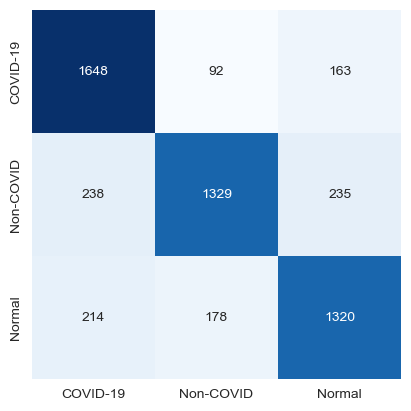

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random = RandomForestClassifier(n_estimators=100, random_state=42)
random.fit(X_train, y_train)

y_pred_random = random.predict(X_val)
store_metrics("RandomForset", random, y_val, y_pred_random)

## KNeighborsClassifier

Accuracy: 0.7323241646667897
Precision: 0.7337892603220508
Recall: 0.7310420141615737
F1 Score: 0.7317502386406184
AUC Score: 0.876048916302891
Confusion Matrix:
[[1469  246  188]
 [ 296 1300  206]
 [ 283  231 1198]]
Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.72      0.77      0.74      1903
   Non-COVID       0.73      0.72      0.73      1802
      Normal       0.75      0.70      0.73      1712

    accuracy                           0.73      5417
   macro avg       0.73      0.73      0.73      5417
weighted avg       0.73      0.73      0.73      5417



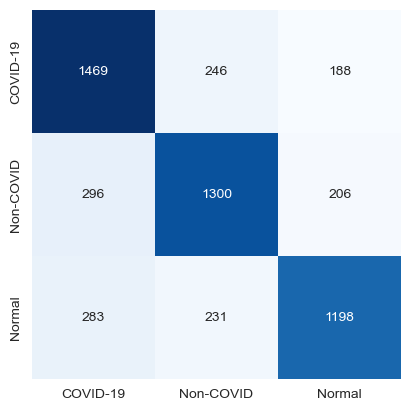

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)

store_metrics("KNeighborsClassifier", knn, y_val, y_pred_knn)

## GradientBoostingClassifier

Accuracy: 0.6424220047997047
Precision: 0.6520041134371908
Recall: 0.6394346681258493
F1 Score: 0.6403583846374783
AUC Score: 0.8242239413590223
Confusion Matrix:
[[1421  241  241]
 [ 495 1066  241]
 [ 481  238  993]]
Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.59      0.75      0.66      1903
   Non-COVID       0.69      0.59      0.64      1802
      Normal       0.67      0.58      0.62      1712

    accuracy                           0.64      5417
   macro avg       0.65      0.64      0.64      5417
weighted avg       0.65      0.64      0.64      5417



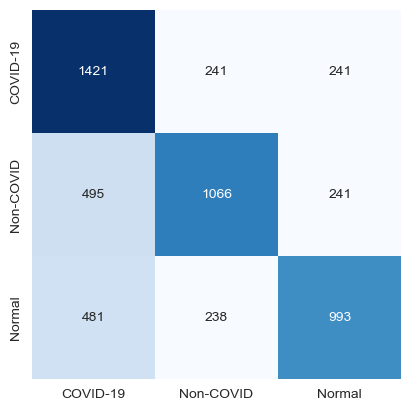

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GRADIENT = GradientBoostingClassifier(n_estimators=5, random_state=42)
GRADIENT.fit(X_train, y_train)

y_pred_GRADIENT = GRADIENT.predict(X_val)
store_metrics("GradientBoostingClassifier", GRADIENT, y_val, y_pred_GRADIENT)

## AdaBoostClassifier

Accuracy: 0.5272290935942403
Precision: 0.5292159471205902
Recall: 0.5285321725874463
F1 Score: 0.5285420625781293
AUC Score: 0.7010755205532666
Confusion Matrix:
[[ 972  523  408]
 [ 595  879  328]
 [ 432  275 1005]]
Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.49      0.51      0.50      1903
   Non-COVID       0.52      0.49      0.51      1802
      Normal       0.58      0.59      0.58      1712

    accuracy                           0.53      5417
   macro avg       0.53      0.53      0.53      5417
weighted avg       0.53      0.53      0.53      5417



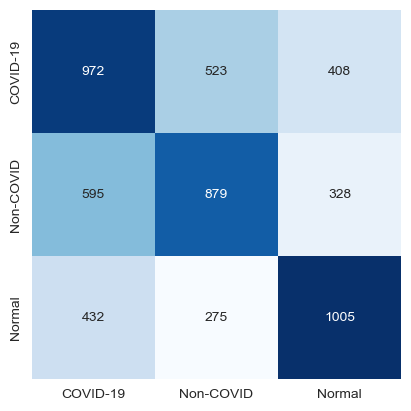

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ADA = AdaBoostClassifier(n_estimators=5, random_state=42)
ADA.fit(X_train, y_train)

y_pred_ADA = ADA.predict(X_val)
store_metrics("AdaBoostClassifier", ADA, y_val, y_pred_ADA)

## GaussianNB

Accuracy: 0.6189772937050028
Precision: 0.6210544153644104
Recall: 0.6212771966060942
F1 Score: 0.6192746557815286
AUC Score: 0.7376086486497101
Confusion Matrix:
[[1044  305  554]
 [ 375 1148  279]
 [ 297  254 1161]]
Classification Report:
              precision    recall  f1-score   support

    COVID-19       0.61      0.55      0.58      1903
   Non-COVID       0.67      0.64      0.65      1802
      Normal       0.58      0.68      0.63      1712

    accuracy                           0.62      5417
   macro avg       0.62      0.62      0.62      5417
weighted avg       0.62      0.62      0.62      5417



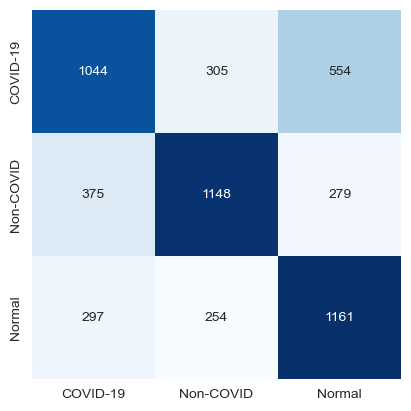

In [ ]:
from sklearn.naive_bayes import GaussianNB
Gaussian = GaussianNB()
Gaussian.fit(X_train, y_train)

y_pred_Gaussian = Gaussian.predict(X_val)
store_metrics("GaussianNB", Gaussian, y_val, y_pred_Gaussian)

In [ ]:
df = pd.DataFrame(l)
df

,0,1,2,3,4,5,6,7
0,RandomForset,0.793243,0.794747,0.791514,0.791532,0.923930,"[[1648, 92, 163], [238, 1329, 235], [214, 178,...",precision recall f1-score ...
1,KNeighborsClassifier,0.732324,0.733789,0.731042,0.731750,0.876049,"[[1469, 246, 188], [296, 1300, 206], [283, 231...",precision recall f1-score ...
2,GradientBoostingClassifier,0.642422,0.652004,0.639435,0.640358,0.824224,"[[1421, 241, 241], [495, 1066, 241], [481, 238...",precision recall f1-score ...
3,AdaBoostClassifier,0.527229,0.529216,0.528532,0.528542,0.701076,"[[972, 523, 408], [595, 879, 328], [432, 275, ...",precision recall f1-score ...
4,GaussianNB,0.618977,0.621054,0.621277,0.619275,0.737609,"[[1044, 305, 554], [375, 1148, 279], [297, 254...",precision recall f1-score ...


In [ ]:
for i in l:
    for j in i:
        print(j)

RandomForset
0.793243492708141
0.7947472145422115
0.7915143206097482
0.7915322020458354
0.9239297152708889
[[1648   92  163]
 [ 238 1329  235]
 [ 214  178 1320]]
              precision    recall  f1-score   support

    COVID-19       0.78      0.87      0.82      1903
   Non-COVID       0.83      0.74      0.78      1802
      Normal       0.77      0.77      0.77      1712

    accuracy                           0.79      5417
   macro avg       0.79      0.79      0.79      5417
weighted avg       0.79      0.79      0.79      5417

KNeighborsClassifier
0.7323241646667897
0.7337892603220508
0.7310420141615737
0.7317502386406184
0.876048916302891
[[1469  246  188]
 [ 296 1300  206]
 [ 283  231 1198]]
              precision    recall  f1-score   support

    COVID-19       0.72      0.77      0.74      1903
   Non-COVID       0.73      0.72      0.73      1802
      Normal       0.75      0.70      0.73      1712

    accuracy                           0.73      5417
   macro avg   